source: https://keras.io/examples/timeseries/timeseries_weather_forecasting/

Raw data visualisation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import LeakyReLU
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
from zipfile import ZipFile
import os


df = pd.read_csv("air_pollution_smog_1.csv")

In [3]:
print(df.head())
df.pop("entry_id")
df.describe()


                  date  entry_id   PM1  PM2.5  PM10   temp    pressure  \
0  2021-11-12T20:30:17         1   0.0    0.0   0.0  26.47  1022.04517   
1  2021-11-12T20:30:35         2  22.0   33.0  38.0  26.67  1022.39905   
2  2021-11-12T20:30:52         3  23.0   35.0  44.0  26.69  1022.33557   
3  2021-11-12T20:31:10         4  25.0   39.0  48.0  26.71  1022.28021   
4  2021-11-12T20:31:41         5  24.0   38.0  45.0  26.73  1022.37970   

   humidity  
0  39.31152  
1  39.24609  
2  39.18848  
3  39.74805  
4  39.12109  


,PM1,PM2.5,PM10,temp,pressure,humidity
count,260381.000000,260380.000000,260380.000000,260380.000000,260380.000000,260380.000000
mean,27.901529,44.170758,55.388482,5.891992,1014.162922,60.599705
std,17.790023,32.212376,40.207758,15.261725,98.571549,19.683561
min,0.000000,0.000000,0.000000,-142.710010,-363.195890,0.000000
25%,16.000000,22.000000,26.000000,1.090000,1014.038180,47.446290
50%,26.000000,40.000000,50.000000,3.750000,1023.121950,65.730470
75%,36.000000,57.000000,75.000000,7.690000,1029.494870,75.936765
max,286.000000,702.000000,948.000000,194.990010,2154.949460,100.000000


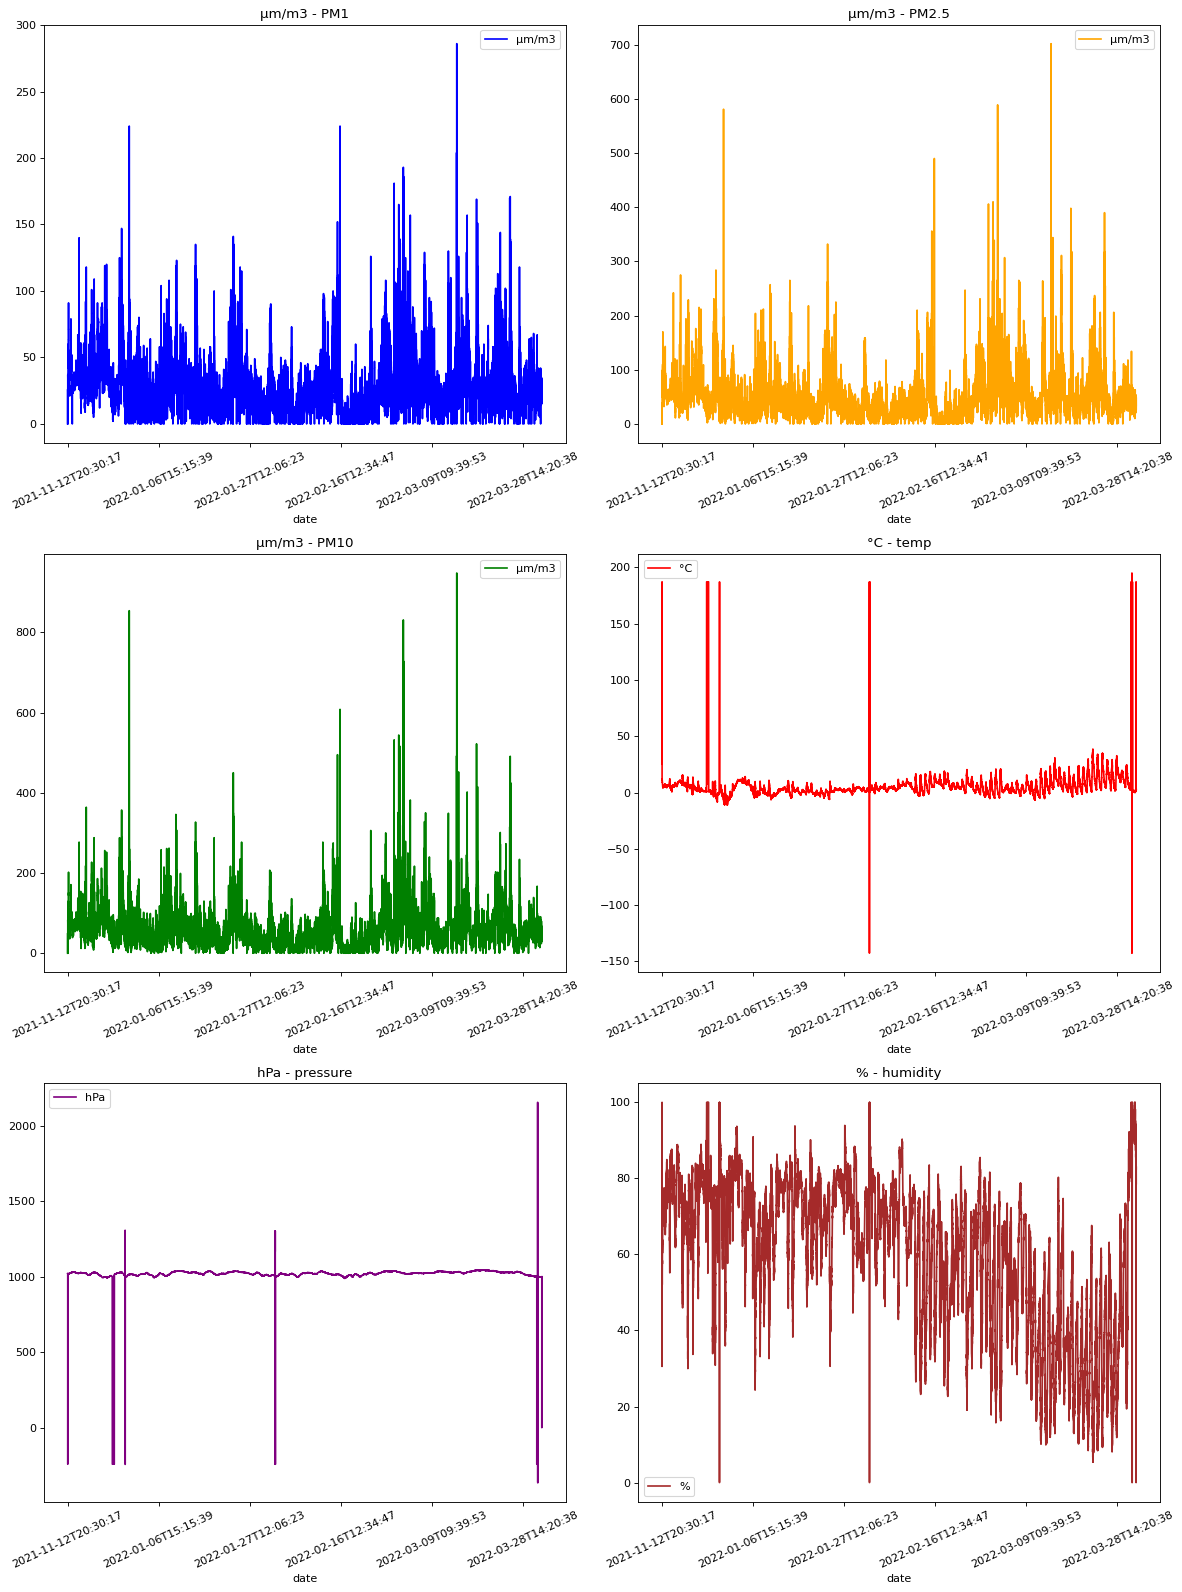

In [4]:
titles = [
    "μm/m3",
    "μm/m3",
    "μm/m3",
    "°C",
    "hPa",
    "%",
]

feature_keys = [
    "PM1",
    "PM2.5",
    "PM10",
    "temp",
    "pressure",
    "humidity",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    
]

date_time_key = "date"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=3, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

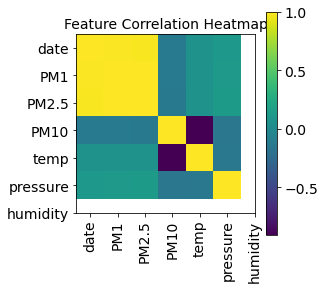

In [5]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)


In [6]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 6

past = 720
future = 72
learning_rate = 0.001
batch_size = 256
epochs = 10


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std


In [7]:
print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 1, 2,3,4,5]]),
)
selected_features = [feature_keys[i] for i in [0, 1, 2,3,4,5]]
print(selected_features)
features = df[selected_features]
features.index = df[date_time_key]
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

The selected parameters are: μm/m3, μm/m3, μm/m3, °C, hPa, %
['PM1', 'PM2.5', 'PM10', 'temp', 'pressure', 'humidity']


In [8]:
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(6)]].values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)

In [9]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [10]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(6)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 120, 6)
Target shape: (256, 1)


In [16]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1), loss="mse" )
# optimizer=keras.optimizers.adam(lr=lr, clipnorm=0.001)  

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 120, 6)]          0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                4992      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________


In [17]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
    batch_size=32,
    
)

Epoch 1/10
724/725 [============================>.] - ETA: 0s - loss: nan

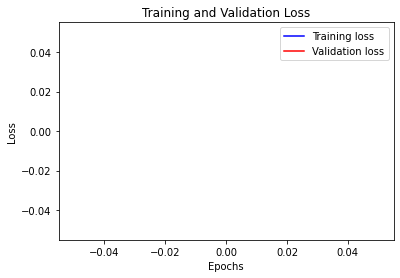

In [ ]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

8/8 [==============================] - 0s 11ms/step


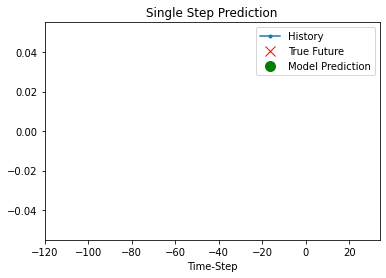

8/8 [==============================] - 0s 9ms/step


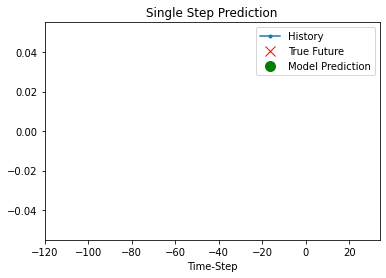

8/8 [==============================] - 0s 9ms/step


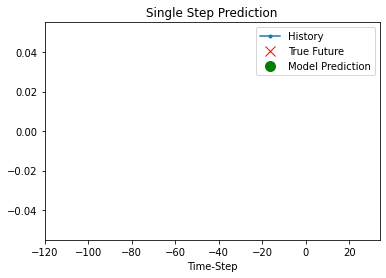

8/8 [==============================] - 0s 9ms/step


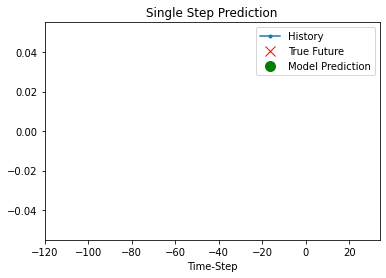

8/8 [==============================] - 0s 10ms/step


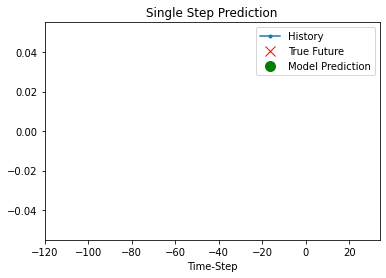

In [ ]:

def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )

8/8 [==============================] - 0s 10ms/step


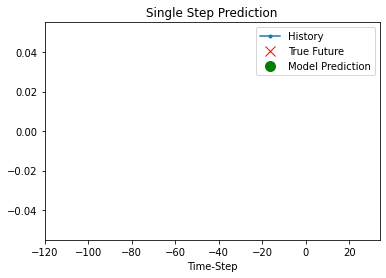

8/8 [==============================] - 0s 10ms/step


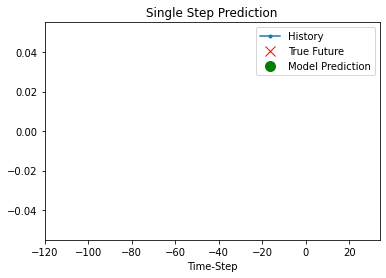

8/8 [==============================] - 0s 10ms/step


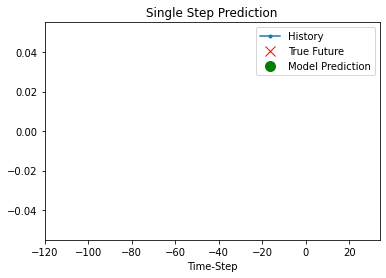

8/8 [==============================] - 0s 9ms/step


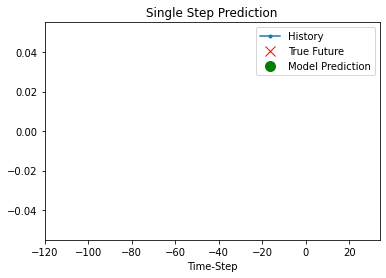

8/8 [==============================] - 0s 10ms/step


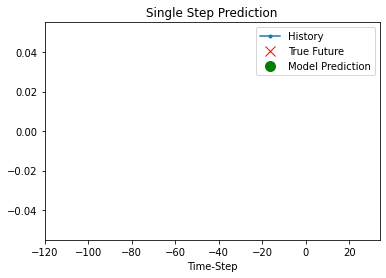

In [ ]:

def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )